## Interpreting the Learning Curves

You might think about the information in the training data as being of two kinds: signal and noise. The signal is the part that generalizes, the part that can help our model make predictions from new data. The noise is that part that is only true of the training data; the noise is all of the random fluctuation that comes from data in the real-world or all of the incidental, non-informative patterns that can't actually help the model make predictions. The noise is the part might look useful but really isn't.

We train a model by choosing weights or parameters that minimize the loss on a training set. You might know, however, that to accurately assess a model's performance, we need to evaluate it on a new set of data, the validation data. (You could see our lesson on model validation in Introduction to Machine Learning for a review.)

When we train a model we've been plotting the loss on the training set epoch by epoch. To this we'll add a plot the validation data too. These plots we call the learning curves. To train deep learning models effectively, we need to be able to interpret them.

This trade-off indicates that there can be two problems that occur when training a model: not enough signal or too much noise. Underfitting the training set is when the loss is not as low as it could be because the model hasn't learned enough signal. Overfitting the training set is when the loss is not as low as it could be because the model learned too much noise. The trick to training deep learning models is finding the best balance between the two.

## Capacity

A model's capacity refers to the size and complexity of the patterns it is able to learn. For neural networks, this will largely be determined by how many neurons it has and how they are connected together. If it appears that your network is underfitting the data, you should try increasing its capacity.

```python
# Code Block
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

wider = keras.Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])

deeper = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

## Early Stopping

We mentioned that when a model is too eagerly learning noise, the validation loss may start to increase during training. To prevent this, we can simply stop the training whenever it seems the validation loss isn't decreasing anymore. Interrupting the training this way is called early stopping.

<div>
<img src="assets/eP0gppr.png" width="500"/>
</div>

Once we detect that the validation loss is starting to rise again, we can reset the weights back to where the minimum occured. This ensures that the model won't continue to learn noise and overfit the data.


## Adding Early Stopping¶

In Keras, we include early stopping in our training through a callback. A callback is just a function you want run every so often while the network trains. The early stopping callback will run after every epoch. (Keras has a variety of useful callbacks pre-defined, but you can define your own, too.)

```python
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [1]:
import pandas as pd
from IPython.display import display

red_wine = pd.read_csv('input/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


In [2]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)

Minimum validation loss: 0.09359366446733475


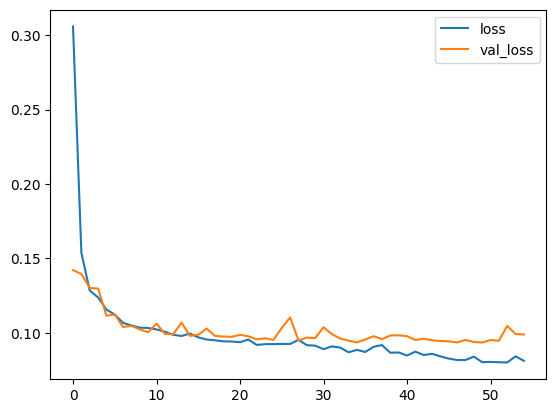

In [3]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [5]:
import matplotlib.pyplot as plt

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

spotify = pd.read_csv('input/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Minimum Validation Loss: 0.1934


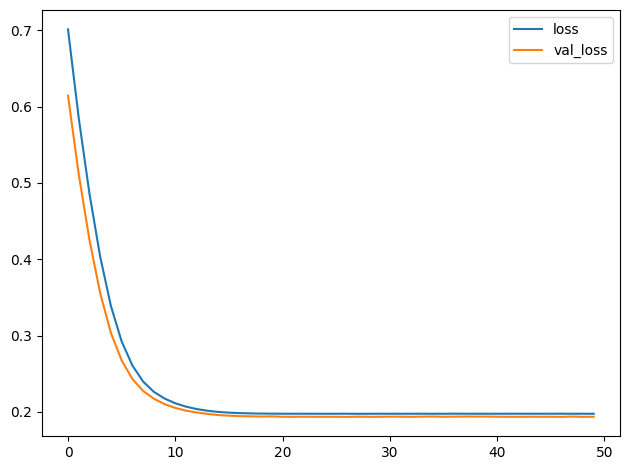

In [10]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1934


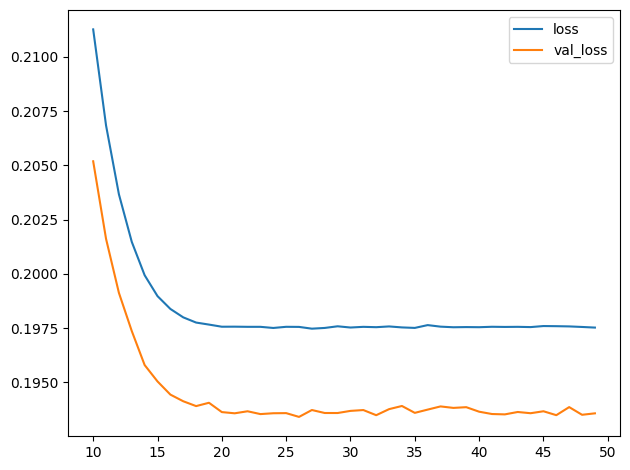

In [11]:
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Epoch 1/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2209 - val_loss: 0.2010
Epoch 2/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1982 - val_loss: 0.1965
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1941 - val_loss: 0.1955
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1916 - val_loss: 0.1940
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1901 - val_loss: 0.1952
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1892 - val_loss: 0.1948
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1875 - val_loss: 0.1939
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1866 - val_loss: 0.1944
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1857 - val_loss: 0.1939
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1846 - val_loss: 0.1942
Epoch 11/50
49/49 [

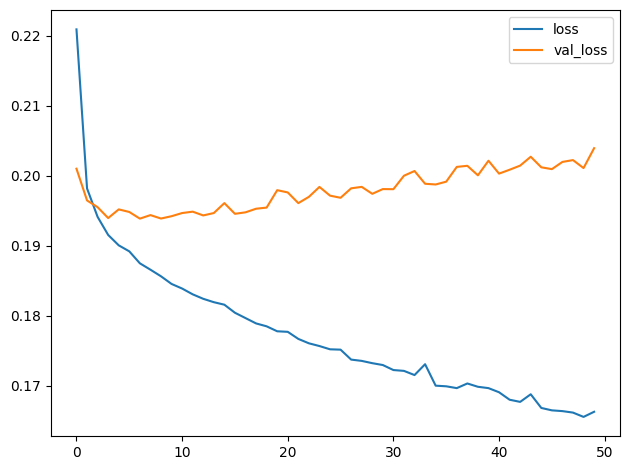

In [12]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [19]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Epoch 1/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2570 - val_loss: 0.2047
Epoch 2/50
49/49 [==============================] - 0s 1ms/step - loss: 0.2040 - val_loss: 0.2000
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1988 - val_loss: 0.1961
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1951 - val_loss: 0.1950
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1930 - val_loss: 0.1944
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1914 - val_loss: 0.1933
Epoch 7/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1902 - val_loss: 0.1951
Epoch 8/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1893 - val_loss: 0.1950
Epoch 9/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1881 - val_loss: 0.1948
Epoch 10/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1876 - val_loss: 0.1939
Epoch 11/50
49/49 [

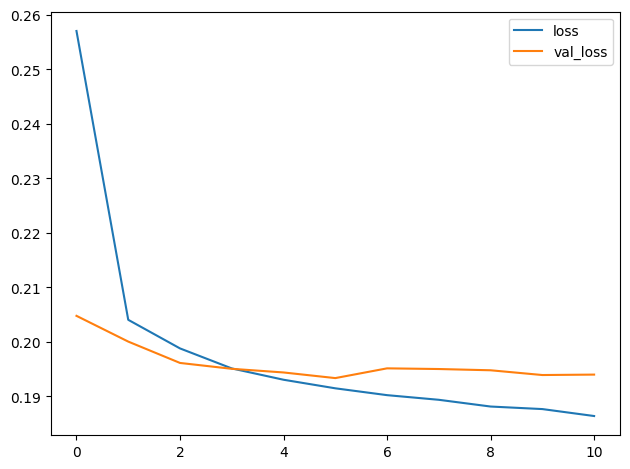

In [20]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));